In [10]:
library(dplyr)
library(readr)
library(DESeq2)
library(ggplot2)
library(tidyr)
library(tibble)
library(viridis)

In [4]:
EPSC_raw_counts_matrix <- read_delim("EPSC_RNAseq_counts.txt", 
                             "\t", escape_double = FALSE, comment = "#", 
                             trim_ws = TRUE)

Parsed with column specification:
cols(
  .default = col_double(),
  Geneid = col_character(),
  Chr = col_character(),
  Start = col_character(),
  End = col_character(),
  Strand = col_character()
)
See spec(...) for full column specifications.


In [6]:
## Changing column names
EPSC_column_names <- c("EPSC_D15_F","EPSC_D7_M",
                       "EPSC_D9_F","EPSC_D7_F",
                       "EPSC_D9_M","EPSC_D15_M",
                       "EPSC_D0_F","EPSC_D0_M",
                       "ESC_D15_M","EPSC_D11_M",
                       "EPSC_D13_F","EPSC_D3_M",
                       "EPSC_D13_M","EPSC_D11_F",
                       "EPSC_D3_F","EPSC_D5_M",
                       "ESC_D15_F","EPSC_D5_F") 
names(EPSC_raw_counts_matrix)[7:24] <- EPSC_column_names 

EPSC_raw_counts_matrix <- EPSC_raw_counts_matrix %>% select(Geneid,EPSC_D0_M,EPSC_D0_F,
                                                   EPSC_D3_M,EPSC_D3_F,
                                                   EPSC_D5_M,EPSC_D5_F,
                                                   EPSC_D7_M,EPSC_D7_F,
                                                   EPSC_D9_M,EPSC_D9_F,
                                                   EPSC_D11_M,EPSC_D11_F,
                                                   EPSC_D13_M,EPSC_D13_F,
                                                   EPSC_D15_M,EPSC_D15_F,
                                                   ESC_D15_M,ESC_D15_F) %>% column_to_rownames("Geneid")

In [17]:
## store sample names (e.g.BT****.sorted.bam)
cell_type <- c(rep("EPSC",16),rep("ESC",2)) 
time <- c(rep(c("Day_0", "Day_3", "Day_5", "Day_7", "Day_9", "Day_11", "Day_13","Day_15", "Day_15_ESCs"), each = 2))
sex <- c(rep(c("Male","Female"),9))
colData <- data.frame(colnames=colnames(EPSC_raw_counts_matrix), cell_type, time,sex, row.names = colnames(EPSC_raw_counts_matrix))
colData

,colnames,cell_type,time,sex
EPSC_D0_M,EPSC_D0_M,EPSC,Day_0,Male
EPSC_D0_F,EPSC_D0_F,EPSC,Day_0,Female
EPSC_D3_M,EPSC_D3_M,EPSC,Day_3,Male
EPSC_D3_F,EPSC_D3_F,EPSC,Day_3,Female
EPSC_D5_M,EPSC_D5_M,EPSC,Day_5,Male
EPSC_D5_F,EPSC_D5_F,EPSC,Day_5,Female
EPSC_D7_M,EPSC_D7_M,EPSC,Day_7,Male
EPSC_D7_F,EPSC_D7_F,EPSC,Day_7,Female
EPSC_D9_M,EPSC_D9_M,EPSC,Day_9,Male
EPSC_D9_F,EPSC_D9_F,EPSC,Day_9,Female


In [50]:
# Create a DESeq2 object

EPSC_dds_unbiased <- DESeqDataSetFromMatrix(countData = EPSC_raw_counts_matrix, colData = colData, design = ~ 1)
EPSC_dds_unbiased

converting counts to integer mode


class: DESeqDataSet 
dim: 53278 18 
metadata(1): version
assays(1): counts
rownames(53278): 4933401J01Rik Gm26206 ... mt-Tt mt-Tp
rowData names(0):
colnames(18): EPSC_D0_M EPSC_D0_F ... ESC_D15_M ESC_D15_F
colData names(4): colnames cell_type time sex

In [51]:
keep <- rowSums(counts(EPSC_dds_unbiased)) >= 10
EPSC_dds_unbiased <- EPSC_dds_unbiased[keep,]
EPSC_dds_unbiased$time <- factor(EPSC_dds_unbiased$time, levels = c("Day_0", "Day_3", "Day_5", "Day_7", "Day_9", "Day_11", "Day_13","Day_15","Day_15_ESCs"))
EPSC_rld <- rlog(EPSC_dds_unbiased, blind=TRUE)
EPSC_rld <- EPSC_rld[,EPSC_rld$sex %in% "Male"]

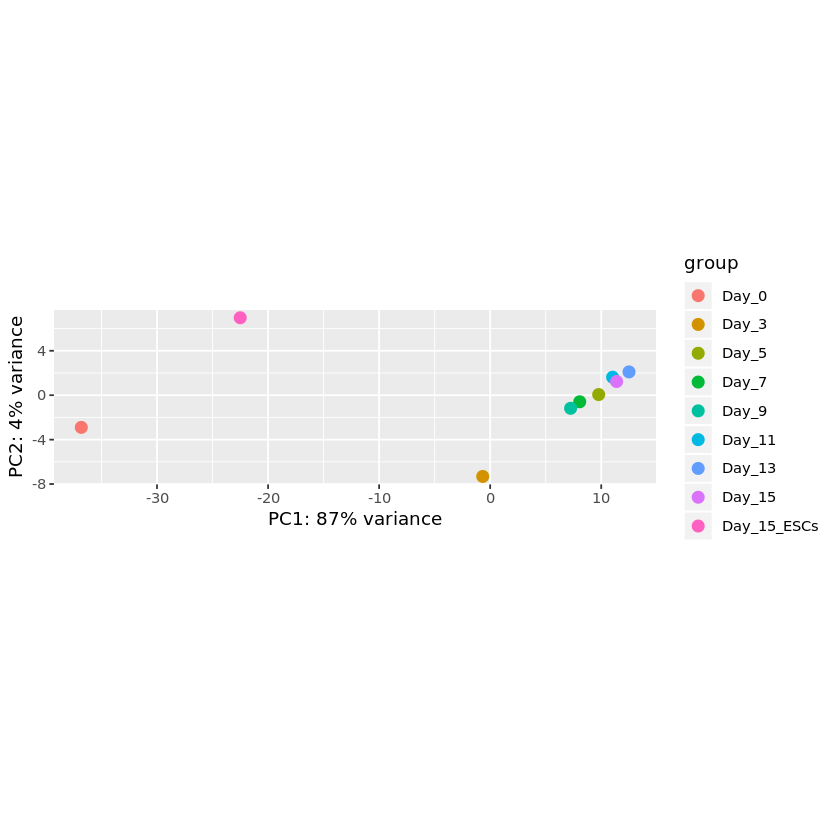

In [52]:
plotPCA(EPSC_rld, intgroup = c("time"))

In [ ]:
# Normalizing by the size factor

EPSC_dds_unbiased_sf <- estimateSizeFactors(EPSC_dds_unbiased)  
sizeFactors(EPSC_dds_unbiased_sf)                          
EPSC_counts_norm <- counts(EPSC_dds_unbiased_sf, normalized=TRUE)       
EPSC_counts_norm_log <- log2(1+EPSC_counts_norm)  

EPSC_counts_norm_log <- as.data.frame(EPSC_counts_norm_log)

### Integrate with MEF data

In [86]:
AJ_0031_counts <- read_delim("AJ_0031_eGFP_counts.txt", 
                             "\t", escape_double = FALSE, comment = "#", 
                             trim_ws = TRUE)

Parsed with column specification:
cols(
  Geneid = col_character(),
  Chr = col_character(),
  Start = col_character(),
  End = col_character(),
  Strand = col_character(),
  Length = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-1-D2_S1_eGFP_Aligned.sortedByCoord.out.bam` = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-2-D8_S2_eGFP_Aligned.sortedByCoord.out.bam` = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-3-D10_S3_eGFP_Aligned.sortedByCoord.out.bam` = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-4-D13_S4_eGFP_Aligned.sortedByCoord.out.bam` = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-5-D15_S5_eGFP_Aligned.sortedByCoord.out.bam` = col_double(),
  `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-6-iPSCs

In [88]:
AJ_0031_counts <- AJ_0031_counts %>%
                        select(Geneid, `/mnt/nfs/data/Vincent_Lab/Adrian_Janiszewski/AJ_0031_Bulk_XCR/fastq/AJ-31-Bulk-1-D2_S1_eGFP_Aligned.sortedByCoord.out.bam`)
colnames(AJ_0031_counts) <- c("Geneid", "MEFs")
AJ_0031_counts <- filter(AJ_0031_counts, Geneid != "pCX_eGFP")
EPSC_MEF_counts <- AJ_0031_counts %>% left_join(rownames_to_column(EPSC_raw_counts_matrix, "Geneid"), by = "Geneid") %>% column_to_rownames("Geneid")

In [100]:
cell_type <- c("MEF",rep("EPSC",16),rep("ESC",2)) 
time <- c("Day_0_MEFs", rep(c("Day_0", "Day_3", "Day_5", "Day_7", "Day_9", "Day_11", "Day_13","Day_15", "Day_15_ESCs"), each = 2))
sex <- c("Female",rep(c("Male","Female"),9))
colData <- data.frame(colnames(EPSC_MEF_counts), cell_type, time,sex, row.names = colnames(EPSC_MEF_counts))
# Create a DESeq2 object
EPSC_dds_unbiased <- DESeqDataSetFromMatrix(countData = EPSC_MEF_counts, colData = colData, design = ~ 1)
EPSC_dds_unbiased

#process
keep <- rowSums(counts(EPSC_dds_unbiased)) >= 10
EPSC_dds_unbiased <- EPSC_dds_unbiased[keep,]
EPSC_dds_unbiased$time <- factor(EPSC_dds_unbiased$time, levels = c("Day_0_MEFs","Day_0", "Day_3", "Day_5", "Day_7", "Day_9", "Day_11", "Day_13","Day_15","Day_15_ESCs"))

#Normalize
EPSC_dds_unbiased_sf <- estimateSizeFactors(EPSC_dds_unbiased)                     
EPSC_counts_norm <- counts(EPSC_dds_unbiased_sf, normalized=TRUE)       
EPSC_counts_norm_log <- log2(1+EPSC_counts_norm)  

EPSC_counts_norm_log <- as.data.frame(EPSC_counts_norm_log)

# Convert to the long format

EPSC_counts_norm_log_long <- gather(EPSC_counts_norm_log, factor_key = TRUE) # Convert from wide to long format
EPSC_counts_norm_log_long$genes <- rep(rownames(EPSC_counts_norm_log),19) # Add the column with gene names
colnames(EPSC_counts_norm_log_long) <- c("sample", "expression","genes")

converting counts to integer mode


class: DESeqDataSet 
dim: 53278 19 
metadata(1): version
assays(1): counts
rownames(53278): 4933401J01Rik Gm26206 ... mt-Tt mt-Tp
rowData names(0):
colnames(19): MEFs EPSC_D0_M ... ESC_D15_M ESC_D15_F
colData names(4): colnames.EPSC_MEF_counts. cell_type time sex

mapping: x = ~sample, y = 7, xend = ~sample, yend = ~expression 
geom_segment: arrow = NULL, arrow.fill = NULL, lineend = butt, linejoin = round, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

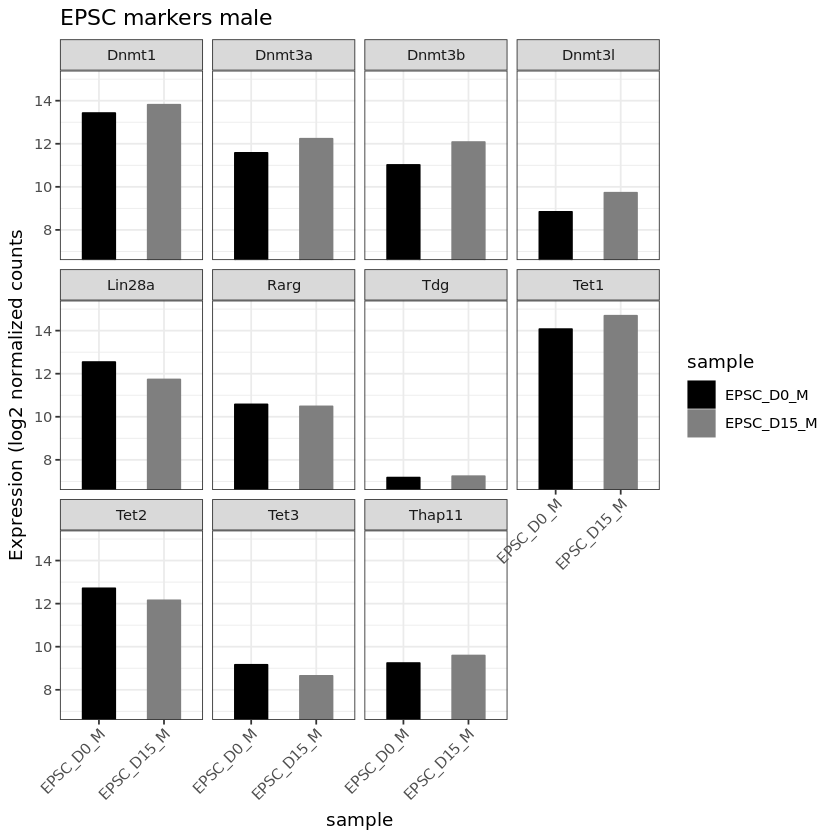

mapping: x = ~sample, y = 7, xend = ~sample, yend = ~expression 
geom_segment: arrow = NULL, arrow.fill = NULL, lineend = butt, linejoin = round, na.rm = FALSE
stat_identity: na.rm = FALSE
position_identity 

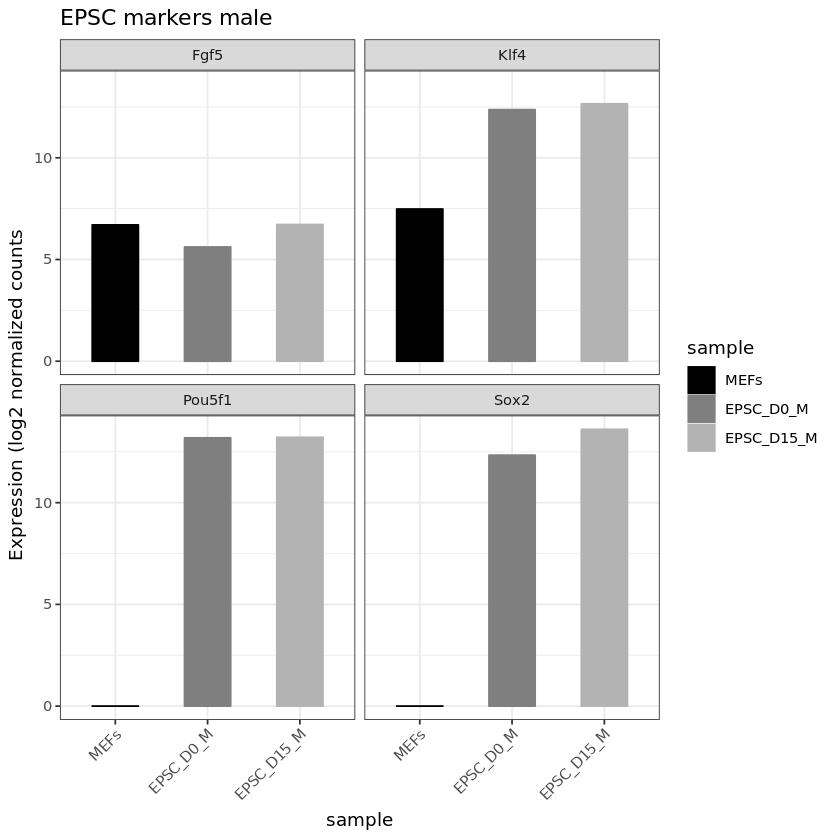

In [109]:
 EPSC_counts_norm_log_long %>% 
            filter(genes %in% c("Dnmt1","Dnmt3a","Dnmt3b","Dnmt3l","Rarg","Lin28a","Tdg","Tet1","Tet2","Tet3","Thap11")) %>%
            filter(sample %in% c("EPSC_D0_M","EPSC_D15_M")) %>%

ggplot(., aes(x = sample, y=expression, color = sample, fill = sample, group = 1))+
  geom_bar(stat='summary', fun.y=sum, width =0.5) +
  scale_fill_manual(values = c("black","grey50", "grey70"))+
  scale_color_manual(values = c("black","grey50", "grey70"))+
  facet_wrap(genes ~.) +
  ggtitle("EPSC markers male")+
  ylab("Expression (log2 normalized counts") +
  coord_cartesian(ylim = c(7,15))+
  theme_bw()+
  theme(axis.text.x = element_text(angle = 45,hjust = 1))
  geom_segment(aes(y = 7, x = sample, xend = sample, yend = expression), color = "grey60", alpha =0)

EPSC_counts_norm_log_long %>% 
            filter(genes %in% c("Fgf5","Klf4","Pou5f1","Sox2")) %>%
            filter(sample %in% c("MEFs","EPSC_D0_M","EPSC_D15_M")) %>%

ggplot(., aes(x = sample, y=expression, color = sample, fill = sample, group = 1))+
  geom_bar(stat='summary', fun.y=sum, width =0.5) +
  scale_fill_manual(values = c("black","grey50", "grey70"))+
  scale_color_manual(values = c("black","grey50", "grey70"))+
  facet_wrap(genes ~.) +
  ggtitle("EPSC markers male")+
  ylab("Expression (log2 normalized counts") +
 
  theme_bw()+
  theme(axis.text.x = element_text(angle = 45,hjust = 1))
  geom_segment(aes(y = 7, x = sample, xend = sample, yend = expression), color = "grey60", alpha =0)


## Differential Gene Expression

In [111]:
group <- rep(c("ESC_D0","EPSC_D3","EPSC_D5","EPSC_D7","EPSC_D9","EPSC_D11","EPSC_D13","EPSC_D15","ESC_D15"), each = 2)
group <- factor(group, levels = c("ESC_D0","EPSC_D3","EPSC_D5","EPSC_D7","EPSC_D9","EPSC_D11","EPSC_D13","EPSC_D15","ESC_D15"))

subset_samples <- c("EPSC_D0_M","EPSC_D0_F",
                                                   "EPSC_D3_M","EPSC_D3_F",
                                                   "EPSC_D5_M","EPSC_D5_F",
                                                   "EPSC_D7_M","EPSC_D7_F",
                                                   "EPSC_D9_M","EPSC_D9_F",
                                                   "EPSC_D11_M","EPSC_D11_F",
                                                   "EPSC_D13_M","EPSC_D13_F",
                                                   "EPSC_D15_M","EPSC_D15_F",
                                                   "ESC_D15_M","ESC_D15_F")
EPSC_dds_unbiased_sub <- EPSC_dds_unbiased[ ,(EPSC_dds_unbiased@colData@rownames %in% subset_samples) ] 
colData(EPSC_dds_unbiased_sub)$group <- group
design(EPSC_dds_unbiased_sub) <- ~ group # Assign design to gruop
design(EPSC_dds_unbiased_sub) # Check design

In [120]:
DEG_mtx <- data.frame(columns = group, rows = group)
DEG_mtx <- DEG_mtx %>% expand(columns, rows)

In [122]:
# Function to return number of differentially expressed genes for each permutation of samples

getNoDEG <- function(object, groupingColumn, contrast1, contrast2){
    # Object is DESeq2 object after running DESeq function (DGEA)
    
    DEGs <- results(object, contrast = c(groupingColumn, contrast1, contrast2))
    
    NoDEG <- sum(DEGs$padj < 0.05, na.rm=TRUE)
    
    return(NoDEG)
}

In [123]:
noDEGs_list <- list()

for (i in 1:nrow(DEG_mtx)){    
    if(DEG_mtx[[i,1]] == DEG_mtx[[i,2]]){
        noDEGs_list[[i]] <- 0
    } else {
    noDEGs_list[[i]] <- getNoDEG(EPSC_dds_unbiased_sub,"group",
                                 as.character(DEG_mtx[[i,1]]),
                                 as.character(DEG_mtx[[i,2]]))
        }
}

In [124]:
DEG_mtx$noDEGs <- noDEGs_list
DEG_mtx$noDEGs <- as.integer(DEG_mtx$noDEGs)

In [125]:
DEG_mtx %>%
filter(columns != "ESC_D15", rows != "ESC_D15") %>% write.csv(., "Numbers_of_DEGs_source_data_ext2a.csv")

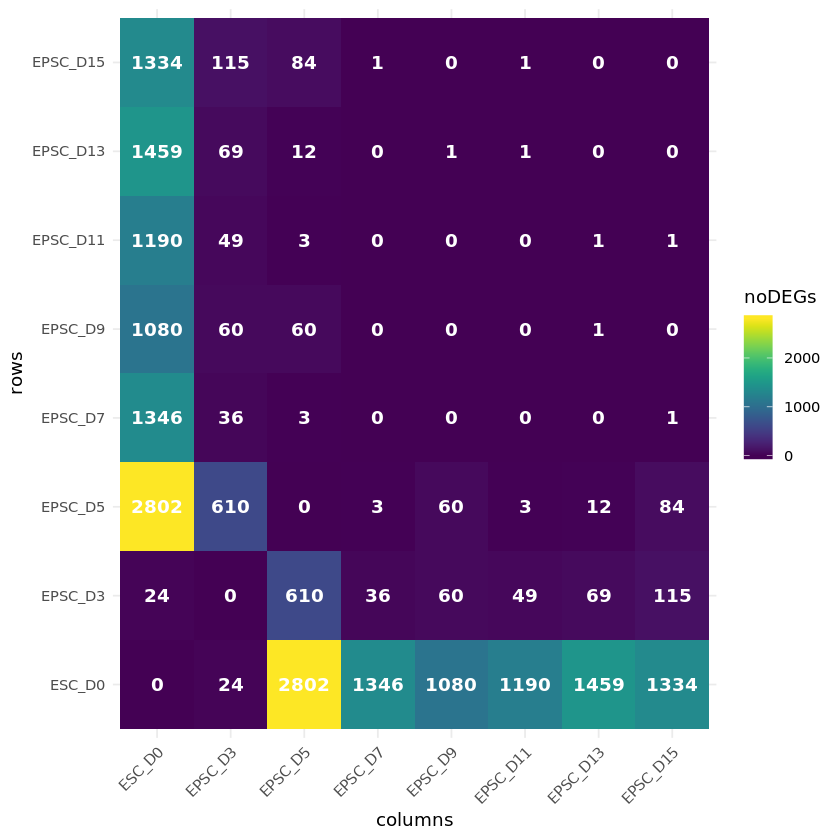

In [126]:
DEG_heatmap <- DEG_mtx %>%
filter(columns != "ESC_D15", rows != "ESC_D15") %>%
ggplot(., aes(columns, rows, fill = noDEGs, label = noDEGs)) + 
    geom_tile() + 
    geom_text(fontface = "bold", color = "white") +
    theme_minimal() + 
    theme(axis.text.x = element_text(angle = 45,hjust = 1)) + 
    scale_fill_viridis()

DEG_heatmap

### Export all possible results of DEGs

In [233]:
for (i in 1:nrow(DEG_mtx)){    
    if(DEG_mtx[[i,1]] != DEG_mtx[[i,2]]){
        
        #next
        
        result <- results(EPSC_dds_unbiased_sub, contrast = c("group",
                                 as.character(DEG_mtx[[i,1]]),
                                 as.character(DEG_mtx[[i,2]])))
        result %>%
            write.table(paste("DGEA/",as.character(DEG_mtx[[i,1]]),"_",
                             as.character(DEG_mtx[[i,2]]),"_all.csv"))
        
        subset(result, result$padj < 0.05) %>%
            write.table(paste("DGEA/",as.character(DEG_mtx[[i,1]]),"_",
                             as.character(DEG_mtx[[i,2]]),"_p0_05.csv"))
        }
}

In [127]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vsc-hard-mounts/leuven-data/320/vsc32023/miniconda/envs/R_scRNAseq/lib/R/lib/libRblas.so

locale:
[1] C

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] viridis_0.5.1               viridisLite_0.3.0          
 [3] tibble_2.1.1                tidyr_0.8.3                
 [5] ggplot2_3.1.1               DESeq2_1.26.0              
 [7] SummarizedExperiment_1.16.0 DelayedArray_0.12.0        
 [9] BiocParallel_1.20.0         matrixStats_0.56.0         
[11] Biobase_2.46.0              GenomicRanges_1.38.0       
[13] GenomeInfoDb_1.22.0         IRanges_2.20.0             
[15] S4Vectors_0.24.0            BiocGenerics_0.32.0        
[17] readr_1.3.1                 dplyr_0.8.0.1              

loaded via a namespace (and not attached):
 